# How-to Finetune

**Before we start**

- This tutorial is rendered from a Jupyter notebook that is hosted on GitHub. If you want to run the code yourself, you can find the notebook and configuration files [here](https://github.com/neuralhydrology/neuralhydrology/tree/master/examples/06-Finetuning).
- To be able to run this notebook locally, you need to download the publicly available CAMELS US rainfall-runoff dataset and a publicly available extensions for hourly forcing and streamflow data. See the [Data Prerequisites Tutorial](data-prerequisites.nblink) for a detailed description on where to download the data and how to structure your local dataset folder. Note the special [section](data-prerequisites.nblink#CAMELS-US-catchment-attributes) with additional requirements for this tutorial.

This tutorial shows how to adapt a pretrained model to a different, eventually much smaller dataset, a concept called finetuning. Finetuning is well-established in machine learning and thus nothing new. Generally speaking, the idea is to use a (very) large and diverse dataset to learn a general understanding of the underlying problem first and then, in a second step, adapt this general model to the target data. Usually, especially if the available target data is limited, pretraining plus finetuning yields (much) better results than only considering the final target data. 

The connection to hydrology is the following: Often, researchers or operators are only interested in a single basin. However, considering that a Deep Learning (DL) model has to learn all (physical) process understanding from the available training data, it might be understandable that the data records of a single basin might not be enough (see e.g. the presentation linked at [this](https://meetingorganizer.copernicus.org/EGU2020/EGU2020-8855.html) EGU'20 abstract)

This is were we apply the concept of pretraining and finetuning: First, we train a DL model (e.g. an LSTM) with a large and diverse, multi-basin dataset (e.g. CAMELS) and then finetune this model to our basin of interest. Everything you need is available in the NeuralHydrology package and in this notebook we will give you an overview of how to actually do it.

**Note**: Finetuning can be a tedious task and is usually very sensitive to the learning rate as well as the number of epochs used for finetuning. One reason is that the pretrained models are usually quite large. In fact, most often they are much larger than what would be possible to train for just a single basin. So during finetuning, we have to make sure that this large capacity is not negatively impacting our model results. Common approaches are to a) only allow parts of the model to be adapted during finetuning and/or b) to train with a much lower learning rate. So far, no publication was published that presents a universally working approach for finetuning in hydrology. So be aware that the results may vary and you might need to invest some time before finding a good strategy. However, in our experience it was always possible to get better results _with_ finetuning than without.

**To summarize**: If you are interested in getting the best-performing Deep Learning model for a single basin, pretraining on a large and diverse dataset, followed by finetuning the pretrained model on your target basin is the way to go.

In [1]:
# Imports
from pathlib import Path

import pandas as pd
import torch
from neuralhydrology.nh_run import start_run, eval_run, finetune

## Pretraining

In the first step, we need to pretrain our model on a large and possibly diverse dataset. Our target basin does not necessarily have to be a part of this dataset, but usually it should be better to include it.

For the sake of the demonstration, we will train an LSTM on the CAMELS US dataset and then finetune this model to a random basin. Note that it is possible to use other inputs during pretraining and finetuning, if additional embedding layers (before the LSTM) are used, which we will ignore for now. Furthermore, we will concentrate only on demonstrating the "how-to" rather than striving for best-possible performance. To save time and energy, we will only pretrain the model for a small number of epochs. When striving for the best possible performance, you should make sure that you pretrain the model as best as possible, before starting to finetune.

We will stick closely to the model and experimental setup from [Kratzert et al. (2019)](https://hess.copernicus.org/articles/23/5089/2019/hess-23-5089-2019.html). To summarize:
- A single LSTM layer with a hidden size of 128.
- Input sequences are 365 days and the prediction is made at the last timestep.
- We will use the same CAMELS attributes, as in the publication mentioned above, as additional inputs at every time step so that the model can learn different hydrological behaviors depending on the catchment properties.

For more details, take a look at the config print-out below.

**Note**
- The config file assumes that the CAMELS US dataset is stored under `data/CAMELS_US` (relative to the main directory of this repository) or a symbolic link exists at this location. Make sure that this folder contains the required subdirectories `basin_mean_forcing`, `usgs_streamflow` and `camels_attributes_v2.0`. If your data is stored at a different location and you can't or don't want to create a symbolic link, you will need to change the `data_dir` argument in the `531_basins.yml` config file that is located in the same directory as this notebook.
- By default, the config (`531_basins.yml`) assumes that you have a CUDA-capable NVIDIA GPU (see config argument `device`). In case you don't have any or you have one but want to train on the CPU, you can either change the config argument to `device: cpu` or pass `gpu=-1` to the `start_run()` function. Please note that training such a model on such a large dataset on CPU takes a very long time. 
- If you want to train on MacOS devices with Metal programming framework which enables high-performance training on GPU for MacOS, change the config argument to `device: mps` and don't pass the `gpu` argument to the `start_run()` function.

We end with an okay'ish model that should be enough for the purpose of this demonstration. Remember we only train for a limited number of epochs here.

Next, we'll load the validation results into memory so we can select a basin to demonstrate how to finetune based on the model performance. 
Since the folder name is created dynamically (including the date and time of the start of the run) you will need to change the `run_dir` argument according to your local directory name. 

Here, we will select a random basin from the lower 50% of the NSE distribution, i.e. a basin where the NSE is below the median NSE. Usually, you'll see better performance gains for basins with lower model performance than for those where the base model is already really good.

In [2]:
run_dir = Path("runs/Zwalm_2402_181607/")
df = pd.read_csv(run_dir / "validation" / "model_epoch049" / "validation_metrics.csv", dtype={'basin': str})
df = df.set_index('basin')
print(f"Median NSE of the validation period {df['NSE'].median():.3f}")
basin = df.loc['6'] 
print(df)
print(basin)
# print(df.index == basin)
# print(df.loc[df.index == basin, 'NSE'])
# print(f"Selected basin: {basin} with an NSE of {df.loc[df.index == basin, 'NSE'].values[0]:.3f}")

Median NSE of the validation period 0.421
            NSE
basin          
6      0.421135
NSE    0.421135
Name: 6, dtype: float64


## Finetuning

Next, we will show how to perform finetuning for the basin selected above, based on the model we just trained. The function to use is `finetune` from `neuralhydrology.nh_run` if you want to train from within a script or notebook. If you want to start finetuning from the command line, you can also call the `nh-run` utility with the `finetune` argument, instead of e.g. `train` or `evaluate`.

The only thing required, similar to the model training itself, is a config file. This config however has slightly different requirements to a normal model config and works slightly different:
- The config has to contain the following two arguments:
    - `base_run_dir`: The path to the directory of the pre-trained model.
    - `finetune_modules`: Which parts of the pre-trained model you want to finetune. Check the documentation of each model class for a list of all possible parts. Often only parts, e.g. the output layer, are trained during finetuning and the rest is kept fixed. There is no general rule of thumb and most likely you will have to try both.
- Any additional argument contained in this config will overwrite the config argument of the pre-trained model. Everything _not_ specified will be taken from the pre-trained model. That is, you can e.g. specify a new basin file in the finetuning config (by `train_basin_file`) to finetune the pre-trained model on a different set of basins, or even just a single basin as we will do in this notebook. You can also change the learning rate, loss function, evaluation metrics and so on. The only thing you can not change are arguments that change the model architecture (e.g. `model`, `hidden_size` etc.), because this leads to errors when you try to load the pre-trained weights into the initialized model.

Let's have a look at the `finetune.yml` config that we prepared for this tutorial (you can find the file in the same directory as this notebook).

In [3]:
!cat finetune.yml

'cat' is not recognized as an internal or external command,
operable program or batch file.


So out of the two arguments that are required, `base_run_dir` is still missing. We will add the argument from here and point at the directory of the model we just trained. Furthermore, we point to a new file for training, validation and testing, called `finetune_basin.txt`, which does not yet exist. We will create this file and add the basin we selected above as the only basin we want to use here. The rest are some changes to the learning rate and the number of training epochs as well as a new name. Also note that here, we train the full model, by selecting all model parts available for the `CudaLSTM` under `finetune_modules`.

In [4]:
print(run_dir.absolute())

e:\Users\ddknop\neuralhydrology_2_updated\runs\Zwalm_2402_181607


In [5]:
# Add the path to the pre-trained model to the finetune config
with open("finetune.yml", "a") as fp:
    fp.write(f"\nbase_run_dir: {run_dir.absolute()}")
    
# # Create a basin file with the basin we selected above
# with open("finetune_basin.txt", "w") as fp:
#     fp.write(basin)

With that, we are ready to start the finetuning. As mentioned above, we have two options to start finetuning:
1. Call the `finetune()` function from a different Python script or a Jupyter Notebook with the path to the config.
2. Start the finetuning from the command line by calling

```bash
nh-run finetune --config-file /path/to/config.yml
```

Here, we will use the first option.

In [8]:
finetune(Path("finetune.yml"))

2025-05-22 18:01:35,558: Logging to e:\Users\ddknop\neuralhydrology_2_updated\runs\Zwalm_finetune_2205_180135\output.log initialized.
2025-05-22 18:01:35,558: ### Folder structure created at e:\Users\ddknop\neuralhydrology_2_updated\runs\Zwalm_finetune_2205_180135
2025-05-22 18:01:35,559: ### Start finetuning with pretrained model stored in e:\Users\ddknop\neuralhydrology_2_updated\runs\Zwalm_2402_181607
2025-05-22 18:01:35,560: ### Run configurations for Zwalm_finetune
2025-05-22 18:01:35,560: batch_size: 512
2025-05-22 18:01:35,560: cache_validation_data: True
2025-05-22 18:01:35,561: checkpoint_path: None
2025-05-22 18:01:35,561: clip_gradient_norm: 1
2025-05-22 18:01:35,562: clip_targets_to_zero: ['streamflow']
2025-05-22 18:01:35,562: commit_hash: None
2025-05-22 18:01:35,563: data_dir: output_caravan
2025-05-22 18:01:35,563: dataset: caravan
2025-05-22 18:01:35,564: device: cpu
2025-05-22 18:01:35,564: dynamic_inputs: ['potential_evaporation_sum_FAO_PENMAN_MONTEITH', 'total_preci

d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\training\basetrainer.py:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_s

# Epoch 1:  61%|██████    | 17/28 [00:13<00:09,  1.22it/s, Loss: 0.1557]


KeyboardInterrupt: 

Looking at the validation result, we can see an increase of roughly 0.05 NSE.

Last but not least, we will compare the pre-trained and the finetuned model on the test period. For this, we will make use of the `eval_run` function from `neuralhydrolgy.nh_run`. Alternatively, you could evaluate both runs from the command line by calling

```bash
nh-run evaluate --run-dir /path/to/run_directory/
```

In [9]:
print(run_dir)

runs\Zwalm_2402_181607


In [10]:
eval_run(run_dir, period="test")

2025-05-22 18:01:57,727: Using the model weights from runs\Zwalm_2402_181607\model_epoch050.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
2025-05-22 18:01:58,351: Stored metrics at runs\Zwalm_2402_181607\test\model_epoch050\test_metrics.csv
2025-05-22 18:01:58,351: Stored results at runs\Zwalm_2402_181607\test\model_epoch050\test_results.p


Now we can call the `eval_run()` function as above, but pointing to the directory of the finetuned run. By default, this function evaluates the last checkpoint, which can be changed with the `epoch` argument. Here however, we use the default. Again, if you want to run this notebook locally, make sure to adapt the folder name of the finetune run.

In [11]:
finetune_dir = Path("runs/Zwalm_finetune_0605_142618")
eval_run(finetune_dir, period="test")

2025-05-22 18:02:01,430: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch050.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
2025-05-22 18:02:01,719: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch050\test_metrics.csv
2025-05-22 18:02:01,719: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch050\test_results.p


Now let's look at the test period results of the pre-trained base model and the finetuned model for the basin that we chose above.

2025-05-22 18:02:04,672: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch001.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
2025-05-22 18:02:04,971: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch001\test_metrics.csv
2025-05-22 18:02:04,972: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch001\test_results.p
2025-05-22 18:02:04,992: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch002.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
2025-05-22 18:02:05,262: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch002\test_metrics.csv
2025-05-22 18:02:05,263: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch002\test_results.p
2025-05-22 18:02:05,267: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch003.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
2025-05-22 18:02:05,551: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch003\test_metrics.csv
2025-05-22 18:02:05,551: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch003\test_results.p
2025-05-22 18:02:05,567: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch004.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
2025-05-22 18:02:05,867: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch004\test_metrics.csv
2025-05-22 18:02:05,867: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch004\test_results.p
2025-05-22 18:02:05,867: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch005.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
2025-05-22 18:02:06,151: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch005\test_metrics.csv
2025-05-22 18:02:06,151: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch005\test_results.p
2025-05-22 18:02:06,175: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch006.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
2025-05-22 18:02:06,494: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch006\test_metrics.csv
2025-05-22 18:02:06,495: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch006\test_results.p
2025-05-22 18:02:06,501: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch007.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]
2025-05-22 18:02:06,801: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch007\test_metrics.csv
2025-05-22 18:02:06,801: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch007\test_results.p
2025-05-22 18:02:06,817: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch008.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
2025-05-22 18:02:07,103: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch008\test_metrics.csv
2025-05-22 18:02:07,119: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch008\test_results.p
2025-05-22 18:02:07,138: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch009.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
2025-05-22 18:02:07,620: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch009\test_metrics.csv
2025-05-22 18:02:07,621: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch009\test_results.p
2025-05-22 18:02:07,636: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch010.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
2025-05-22 18:02:07,921: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch010\test_metrics.csv
2025-05-22 18:02:07,921: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch010\test_results.p
2025-05-22 18:02:07,952: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch011.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
2025-05-22 18:02:08,222: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch011\test_metrics.csv
2025-05-22 18:02:08,222: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch011\test_results.p
2025-05-22 18:02:08,238: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch012.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
2025-05-22 18:02:08,539: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch012\test_metrics.csv
2025-05-22 18:02:08,539: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch012\test_results.p
2025-05-22 18:02:08,554: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch013.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
2025-05-22 18:02:08,861: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch013\test_metrics.csv
2025-05-22 18:02:08,862: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch013\test_results.p
2025-05-22 18:02:08,876: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch014.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
2025-05-22 18:02:09,174: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch014\test_metrics.csv
2025-05-22 18:02:09,184: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch014\test_results.p
2025-05-22 18:02:09,203: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch015.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
2025-05-22 18:02:09,519: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch015\test_metrics.csv
2025-05-22 18:02:09,519: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch015\test_results.p
2025-05-22 18:02:09,536: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch016.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
2025-05-22 18:02:09,840: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch016\test_metrics.csv
2025-05-22 18:02:09,841: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch016\test_results.p
2025-05-22 18:02:09,855: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch017.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
2025-05-22 18:02:10,138: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch017\test_metrics.csv
2025-05-22 18:02:10,139: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch017\test_results.p
2025-05-22 18:02:10,156: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch018.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
2025-05-22 18:02:10,473: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch018\test_metrics.csv
2025-05-22 18:02:10,474: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch018\test_results.p
2025-05-22 18:02:10,491: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch019.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
2025-05-22 18:02:10,791: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch019\test_metrics.csv
2025-05-22 18:02:10,791: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch019\test_results.p
2025-05-22 18:02:10,807: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch020.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
2025-05-22 18:02:11,141: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch020\test_metrics.csv
2025-05-22 18:02:11,141: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch020\test_results.p
2025-05-22 18:02:11,157: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch021.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
2025-05-22 18:02:11,441: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch021\test_metrics.csv
2025-05-22 18:02:11,450: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch021\test_results.p
2025-05-22 18:02:11,457: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch022.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
2025-05-22 18:02:11,758: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch022\test_metrics.csv
2025-05-22 18:02:11,758: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch022\test_results.p
2025-05-22 18:02:11,773: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch023.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
2025-05-22 18:02:12,078: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch023\test_metrics.csv
2025-05-22 18:02:12,079: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch023\test_results.p
2025-05-22 18:02:12,094: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch024.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]
2025-05-22 18:02:12,406: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch024\test_metrics.csv
2025-05-22 18:02:12,408: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch024\test_results.p
2025-05-22 18:02:12,425: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch025.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
2025-05-22 18:02:12,711: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch025\test_metrics.csv
2025-05-22 18:02:12,717: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch025\test_results.p
2025-05-22 18:02:12,729: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch026.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
2025-05-22 18:02:13,024: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch026\test_metrics.csv
2025-05-22 18:02:13,024: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch026\test_results.p
2025-05-22 18:02:13,042: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch027.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
2025-05-22 18:02:13,350: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch027\test_metrics.csv
2025-05-22 18:02:13,350: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch027\test_results.p
2025-05-22 18:02:13,365: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch028.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
2025-05-22 18:02:13,657: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch028\test_metrics.csv
2025-05-22 18:02:13,657: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch028\test_results.p
2025-05-22 18:02:13,675: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch029.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
2025-05-22 18:02:13,984: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch029\test_metrics.csv
2025-05-22 18:02:13,984: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch029\test_results.p
2025-05-22 18:02:14,000: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch030.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
2025-05-22 18:02:14,318: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch030\test_metrics.csv
2025-05-22 18:02:14,318: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch030\test_results.p
2025-05-22 18:02:14,338: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch031.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
2025-05-22 18:02:14,624: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch031\test_metrics.csv
2025-05-22 18:02:14,625: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch031\test_results.p
2025-05-22 18:02:14,642: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch032.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
2025-05-22 18:02:14,968: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch032\test_metrics.csv
2025-05-22 18:02:14,968: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch032\test_results.p
2025-05-22 18:02:14,984: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch033.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
2025-05-22 18:02:15,291: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch033\test_metrics.csv
2025-05-22 18:02:15,292: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch033\test_results.p
2025-05-22 18:02:15,308: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch034.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
2025-05-22 18:02:15,588: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch034\test_metrics.csv
2025-05-22 18:02:15,589: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch034\test_results.p
2025-05-22 18:02:15,603: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch035.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
2025-05-22 18:02:15,897: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch035\test_metrics.csv
2025-05-22 18:02:15,897: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch035\test_results.p
2025-05-22 18:02:15,917: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch036.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
2025-05-22 18:02:16,201: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch036\test_metrics.csv
2025-05-22 18:02:16,201: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch036\test_results.p
2025-05-22 18:02:16,234: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch037.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
2025-05-22 18:02:16,559: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch037\test_metrics.csv
2025-05-22 18:02:16,559: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch037\test_results.p
2025-05-22 18:02:16,575: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch038.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
2025-05-22 18:02:16,845: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch038\test_metrics.csv
2025-05-22 18:02:16,846: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch038\test_results.p
2025-05-22 18:02:16,859: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch039.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]
2025-05-22 18:02:17,111: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch039\test_metrics.csv
2025-05-22 18:02:17,111: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch039\test_results.p
2025-05-22 18:02:17,127: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch040.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
2025-05-22 18:02:17,418: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch040\test_metrics.csv
2025-05-22 18:02:17,433: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch040\test_results.p
2025-05-22 18:02:17,434: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch041.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]
2025-05-22 18:02:17,742: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch041\test_metrics.csv
2025-05-22 18:02:17,750: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch041\test_results.p
2025-05-22 18:02:17,772: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch042.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]
2025-05-22 18:02:18,084: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch042\test_metrics.csv
2025-05-22 18:02:18,084: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch042\test_results.p
2025-05-22 18:02:18,101: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch043.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
2025-05-22 18:02:18,437: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch043\test_metrics.csv
2025-05-22 18:02:18,438: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch043\test_results.p
2025-05-22 18:02:18,439: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch044.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
2025-05-22 18:02:18,784: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch044\test_metrics.csv
2025-05-22 18:02:18,784: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch044\test_results.p
2025-05-22 18:02:18,801: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch045.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
2025-05-22 18:02:19,118: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch045\test_metrics.csv
2025-05-22 18:02:19,118: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch045\test_results.p
2025-05-22 18:02:19,147: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch046.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
2025-05-22 18:02:19,437: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch046\test_metrics.csv
2025-05-22 18:02:19,438: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch046\test_results.p
2025-05-22 18:02:19,456: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch047.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
2025-05-22 18:02:19,753: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch047\test_metrics.csv
2025-05-22 18:02:19,753: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch047\test_results.p
2025-05-22 18:02:19,770: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch048.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
2025-05-22 18:02:20,088: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch048\test_metrics.csv
2025-05-22 18:02:20,088: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch048\test_results.p
2025-05-22 18:02:20,109: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch049.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]
2025-05-22 18:02:20,458: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch049\test_metrics.csv
2025-05-22 18:02:20,459: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch049\test_results.p
2025-05-22 18:02:20,474: Using the model weights from runs\Zwalm_finetune_0605_142618\model_epoch050.pt


d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_stat

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
2025-05-22 18:02:20,767: Stored metrics at runs\Zwalm_finetune_0605_142618\test\model_epoch050\test_metrics.csv
2025-05-22 18:02:20,769: Stored results at runs\Zwalm_finetune_0605_142618\test\model_epoch050\test_results.p
Epoch 1: NSE = 0.4735
Epoch 2: NSE = 0.5039
Epoch 3: NSE = 0.5061
Epoch 4: NSE = 0.5273
Epoch 5: NSE = 0.5259
Epoch 6: NSE = 0.5340
Epoch 7: NSE = 0.5151
Epoch 8: NSE = 0.5057
Epoch 9: NSE = 0.5099
Epoch 10: NSE = 0.5142
Epoch 11: NSE = 0.5205
Epoch 12: NSE = 0.5228
Epoch 13: NSE = 0.5238
Epoch 14: NSE = 0.5052
Epoch 15: NSE = 0.5209
Epoch 16: NSE = 0.5077
Epoch 17: NSE = 0.5148
Epoch 18: NSE = 0.5006
Epoch 19: NSE = 0.5123
Epoch 20: NSE = 0.5115
Epoch 21: NSE = 0.5078
Epoch 22: NSE = 0.5058
Epoch 23: NSE = 0.5074
Epoch 24: NSE = 0.5060
Epoch 25: NSE = 0.5061
Epoch 26: NSE = 0.5069
Epoch 27: NSE = 0.5050
Epoch 28: NSE = 0.5066
Epoch 29: NSE = 0.5073
Epoch 30: NSE = 0.5053
Epoch 31: NSE = 0.5040
Epoch 32: NSE 

d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\datautils\utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
d:\Users\ddknop\Documents\envs\neuralhydrology\lib\site-packages\neuralhydrology\datautils\utils.py:383: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


NSE: 0.534
MSE: 0.649
RMSE: 0.806
KGE: 0.623
Alpha-NSE: 0.774
Beta-KGE: 1.153
Beta-NSE: 0.117
Pearson-r: 0.741
FHV: -25.021
FMS: -32.177
FLV: 88.364
Peak-Timing: 1.545
Peak-MAPE: 65.300


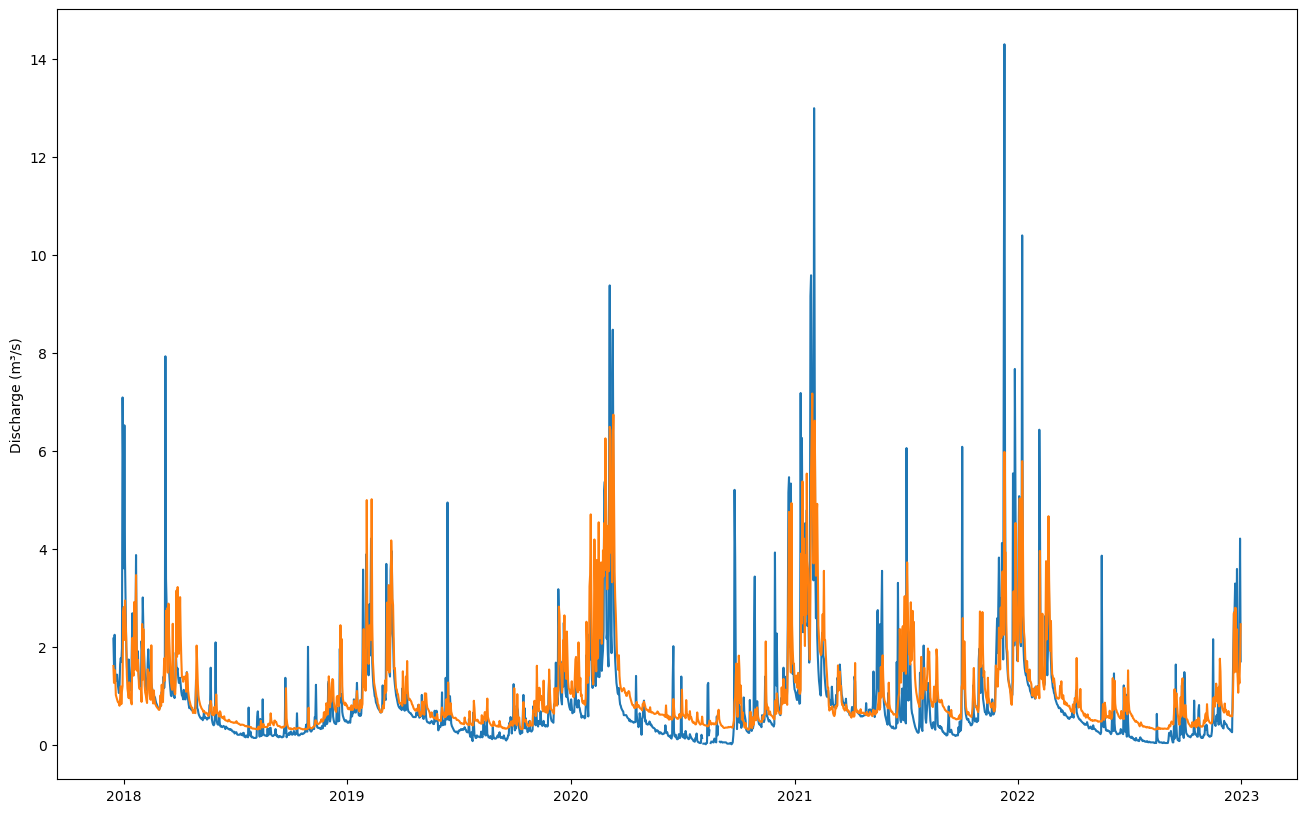

In [12]:

import pickle
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run
import matplotlib.dates as mdates
import os
import numpy as np
area = 111639970.52
run_dir = Path('runs/Zwalm_finetune_0605_142618')
for i in range(1, 51):
    eval_run(epoch = i,run_dir=run_dir, period="test")

# Initialize variables to track the best NSE and the corresponding epoch
max_nse = -float('inf')  # Set to negative infinity initially
best_epoch = None

# Loop through epochs 1 to 50
for i in range(1, 51):  # Epochs 1 to 50
    # Format the folder name for the current epoch
    epoch_folder = finetune_dir/ "test"/ f"model_epoch{i:03d}"
    metrics_file = epoch_folder / "test_metrics.csv"

    # Check if the test_metrics.csv file exists
    if not metrics_file.exists():
        print(f"test_metrics.csv file not found for epoch {i}. Skipping...")
        continue

    # Load the CSV file into a DataFrame
    df = pd.read_csv(metrics_file)

    # Extract the NSE value from the dataframe (assuming NSE is in a column named 'NSE')
    if 'NSE' in df.columns:
        nse_value = df['NSE'].iloc[0]  
        print(f"Epoch {i}: NSE = {nse_value:.4f}")

        # Check if this is the highest NSE found so far
        if nse_value > max_nse:
            max_nse = nse_value
            best_epoch = i

# Output the best epoch and its NSE value
if best_epoch is not None:
    print(f"\nThe epoch with the highest NSE is Epoch {best_epoch} with an NSE value of {max_nse:.4f}")
else:
    print("No NSE values found.")


with open(finetune_dir / "test" / "model_epoch006" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
qobs = results['6']['1D']['xr']['streamflow_obs']*area/(1000*3600*24)
qsim = results['6']['1D']['xr']['streamflow_sim']*area/(1000*3600*24)

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs)
ax.plot(qsim['date'], qsim)
ax.set_ylabel("Discharge (m³/s)")

    #data properties

values = metrics.calculate_all_metrics(qobs.isel(time_step=-1), qsim.isel(time_step=-1))
for key, val in values.items():
    print(f"{key}: {val:.3f}")

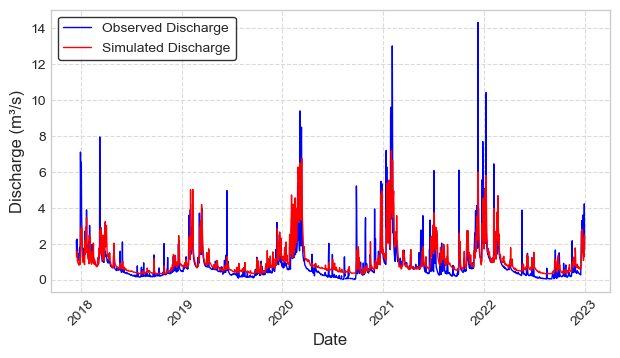

In [16]:
plt.figure(figsize=(6.3, 3.5))

# Plot observed streamflow
plt.plot(qobs['date'], qobs, label='Observed Discharge', color='blue', linewidth=1)

# Plot simulated streamflow
plt.plot(qobs['date'], qsim, label='Simulated Discharge', color='red', linewidth = 1)

# Add axis labels and styling
plt.xlabel('Date', fontsize=12)
plt.ylabel('Discharge (m³/s)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=45)
plt.style.use('seaborn-v0_8-whitegrid')

# Add legend
plt.legend(frameon=True, edgecolor='black')
plt.savefig("Final_output_finetuned_single.png", dpi=1000, bbox_inches='tight') 
# Show plot
plt.show()

In [14]:
print(qobs)
print(qsim)
qsim_avg = qsim.mean(skipna = True)
qobs_avg = qobs.mean(skipna=True)
print(qsim_avg)
print(qobs_avg)
qsim_avg.values/qobs_avg.values

<xarray.DataArray 'streamflow_obs' (date: 1843, time_step: 1)>
array([[2.17077704],
       [1.61516148],
       [2.248305  ],
       ...,
       [1.70561074],
       [4.21234148],
       [1.70561074]])
Coordinates:
  * date       (date) datetime64[ns] 2017-12-15 2017-12-16 ... 2022-12-31
  * time_step  (time_step) int64 0
<xarray.DataArray 'streamflow_sim' (date: 1843, time_step: 1)>
array([[1.61089352],
       [1.26685528],
       [1.53111861],
       ...,
       [1.25852574],
       [1.7312987 ],
       [2.46348648]])
Coordinates:
  * date       (date) datetime64[ns] 2017-12-15 2017-12-16 ... 2022-12-31
  * time_step  (time_step) int64 0
<xarray.DataArray 'streamflow_sim' ()>
array(1.03674213)
<xarray.DataArray 'streamflow_obs' ()>
array(0.90099976)


1.1506574999560093

In [15]:
def NSE_LF(Qmod, Qobs):
    """
    Calculate the low-flow Nash-Sutcliffe Efficiency (NSE_LF) using inverse flows.
    This variant of NSE emphasizes performance during low-flow periods.

    Only calculates for timestamps where no NaN values are present in the observed flows.

    Parameters
    ----------
    Qmod: numpy.array
        Modelled flows
    Qobs: numpy.array
        Observed flows

    Returns
    -------
    nse_lf: float
        Low-flow Nash-Sutcliffe Efficiency

    """
    nan_bool = np.isnan(Qobs)
    Qmod_nonan = Qmod[~nan_bool]
    Qobs_nonan = Qobs[~nan_bool]

    # Avoid division by zero using epsilon (1/100th of mean observed flow)
    epsilon = np.mean(Qobs_nonan) / 100

    Qmod_inv = 1 / (Qmod_nonan + epsilon)
    Qobs_inv = 1 / (Qobs_nonan + epsilon)

    T = (Qobs_inv - Qmod_inv) ** 2
    N = (Qobs_inv - np.mean(Qobs_inv)) ** 2

    nse_lf = 1 - np.sum(T) / np.sum(N)
    return nse_lf

In [16]:
NSE_LF(qsim.values, qobs.values)

0.029398029474398957

So we see roughly the same performance increase in the test period (slightly higher), which is great. However, note that a) our base model was not optimally trained (we stopped quite early) but also b) the finetuning settings were chosen rather randomly. From our experience so far, you can almost always get performance increases for individual basins with finetuning, but it is difficult to find settings that are universally applicable. However, this tutorial was just a showcase of how easy it actually is to finetune models with the NeuralHydrology library. Now it is up to you to experiment with it.